# Using GPU SVI Sparse calculation for efficiency and scalibity



In [2]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Running this notebook on: ", device)

import spateo as st
print("Last run with spateo version:", st.__version__)

# Other imports
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad
import numpy as np

# Uncomment the following if running on the server
import os
os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
os.environ['DISPLAY'] = ':99'

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

Running this notebook on:  cuda


2024-08-14 23:56:51.074351: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-14 23:56:51.227138: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-08-14 23:56:51.227161: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-08-14 23:56:51.944763: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

Last run with spateo version: 1.0.2.dev519+46c6d93.dirty


(EE) 
Fatal server error:
(EE) Server is already active for display 99
	If this server is no longer running, remove /tmp/.X99-lock
	and start again.
(EE) 


## Small size data

If the spots/cells of the slices are very small, you can use both CPU and GPU

In [15]:
slice1 = st.read('/home/ylu/project/Benchmark_alignment_methods/data/SCC/patient_9_slice_1.h5ad')
slice2 = st.read('/home/ylu/project/Benchmark_alignment_methods/data/SCC/patient_9_slice_2.h5ad')

slice1, slice2

(AnnData object with n_obs × n_vars = 1035 × 10176
     obs: 'original_clusters', 'n_genes'
     var: 'n_cells'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 828 × 8399
     obs: 'original_clusters', 'n_genes'
     var: 'n_cells'
     obsm: 'spatial')

In [ ]:
# import sys
# sys.path.insert(0, "/home/ylu/project")
# from utils import *

# # slices = st.align.split_slice(adata=adata,spatial_key='spatial_raw',split_num=4,axis=2,)
# slices = split_slice(adata=adata,spatial_key='spatial_raw',split_num=2,axis=2,)

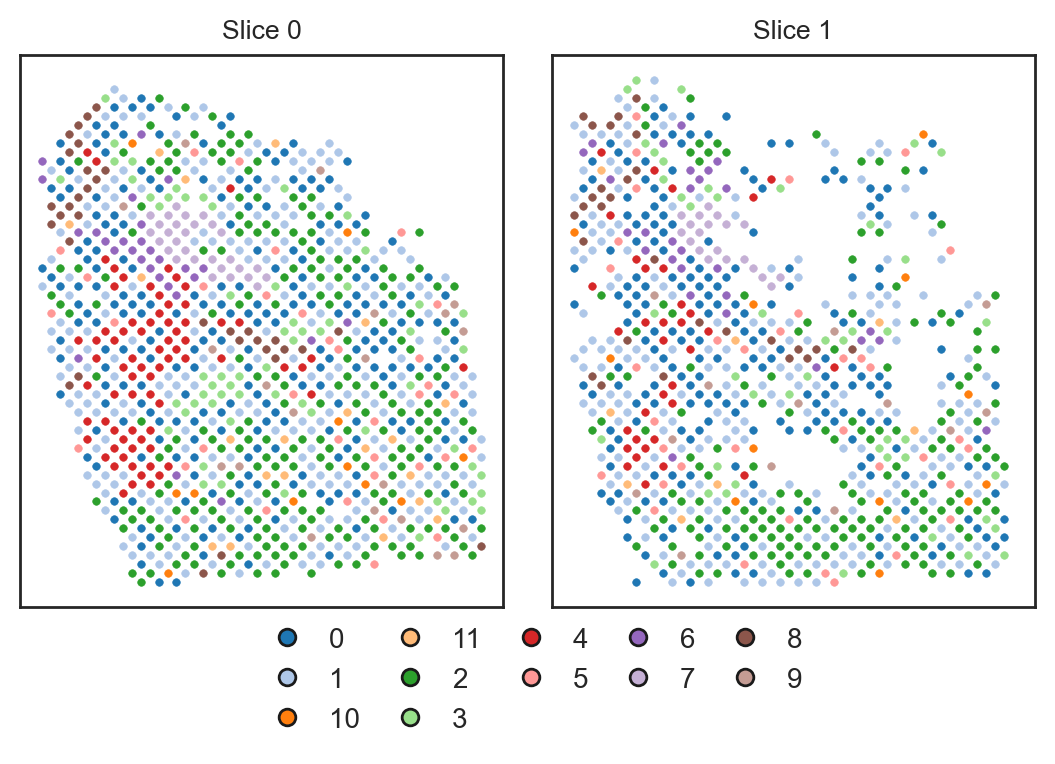

In [16]:
spatial_key = 'spatial'
cluster_key = 'original_clusters'
st.pl.slices_2d(
    slices = [slice1, slice2],
    label_key = cluster_key,
    spatial_key = spatial_key,
    height=4,
    center_coordinate=False,
    show_legend=True,
    legend_kwargs={'loc': 'upper center', 'bbox_to_anchor': (0.49, 0) ,'ncol': 5, 'borderaxespad': -4, 'frameon': False},
)

In [26]:
key_added = 'align_spatial'
# spateo return aligned slices as well as the mapping matrix
aligned_slices, pis = st.align.morpho_align(
    models=[slice1, slice2],
    spatial_key=spatial_key,
    key_added=key_added,
    device=device,
    verbose=False,
)

|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [4.4404s]


In [25]:
key_added = 'align_spatial'
# spateo return aligned slices as well as the mapping matrix
aligned_slices, pis = st.align.morpho_align(
    models=[slice1, slice2],
    spatial_key=spatial_key,
    key_added=key_added,
    device=device,
    verbose=False,
    SVI_mode=False,
)

|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [4.1138s]


In [20]:
key_added = 'align_spatial'
# spateo return aligned slices as well as the mapping matrix
aligned_slices, pis = st.align.morpho_align(
    models=[slice1, slice2],
    spatial_key=spatial_key,
    key_added=key_added,
    device='cpu',
    verbose=False,
)

|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [12.6689s]


In [22]:
key_added = 'align_spatial'
# spateo return aligned slices as well as the mapping matrix
aligned_slices, pis = st.align.morpho_align(
    models=[slice1, slice2],
    spatial_key=spatial_key,
    key_added=key_added,
    device='cpu',
    verbose=False,
    SVI_mode=False,
)

|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [12.6720s]


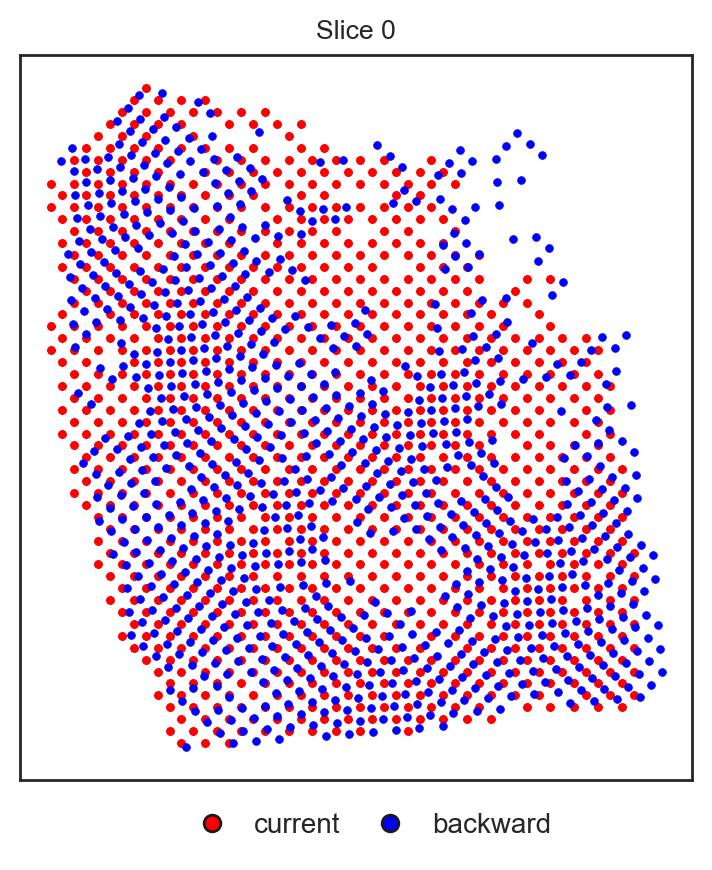

In [27]:
st.pl.overlay_slices_2d(slices = aligned_slices, spatial_key = key_added+'_nonrigid', height=5, overlay_type='backward')

## Middle size data

In [30]:
# Load the slices
slice1 = st.read('./data/basic_usage_demo_1.h5ad')
slice2 = st.read('./data/basic_usage_demo_2.h5ad')

slice1.layers["counts"] = slice1.X.copy()
sc.pp.normalize_total(slice1)
sc.pp.log1p(slice1)
sc.pp.filter_cells(slice1, min_genes=10)
sc.pp.filter_genes(slice1, min_cells=3)
sc.pp.highly_variable_genes(slice1, n_top_genes=2000)

slice2.layers["counts"] = slice2.X.copy()
sc.pp.normalize_total(slice2)
sc.pp.log1p(slice2)
sc.pp.filter_cells(slice2, min_genes=10)
sc.pp.filter_genes(slice2, min_cells=3)
sc.pp.highly_variable_genes(slice2, n_top_genes=2000)

slice1, slice2

(AnnData object with n_obs × n_vars = 17425 × 19506
     obs: 'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'louvain', 'cellbin_SpatialDomain', 'n_genes'
     var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: '__type', 'louvain', 'neighbors', 'pca', 'pearson_residuals_normalization', 'spatial', 'log1p', 'hvg'
     obsm: 'X_pca', 'X_spatial', 'bbox', 'spatial'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 19939 × 19699
     obs: 'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'louvain', 'cellbin_SpatialDomain', 'n_genes'
     var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: '__type', 'louvain', 'neighbors', 'pca', 'pearson_residuals_normalization', 'spatial', 'log1p', 'hvg'
     obsm: 'X_pca', 'X_spatial', 'bbox', 'spatial'
     layers: 'counts')

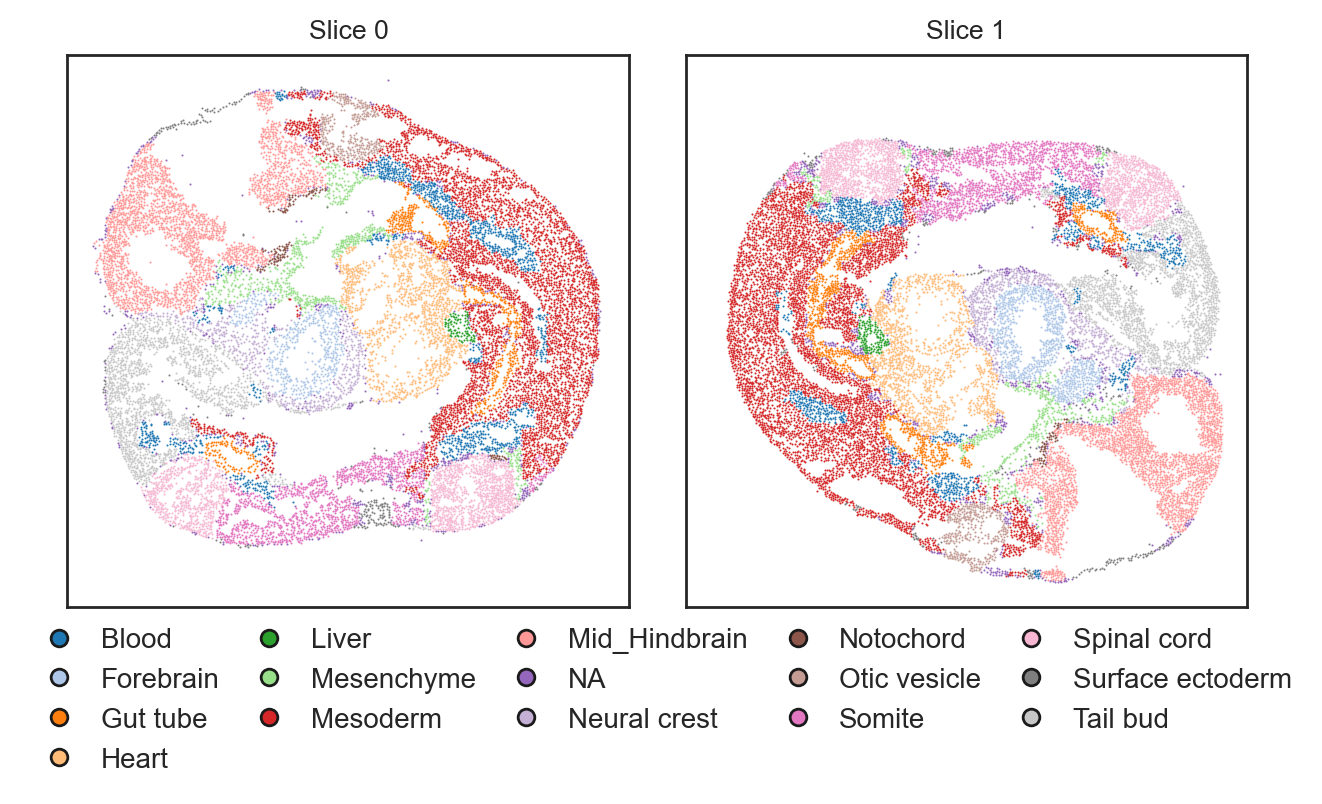

In [29]:
spatial_key = 'spatial'
cluster_key = 'cellbin_SpatialDomain'

st.pl.slices_2d(
    slices = [slice1, slice2],
    label_key = cluster_key,
    spatial_key = spatial_key,
    height=4,
    center_coordinate=True,
    show_legend=True,
    legend_kwargs={'loc': 'upper center', 'bbox_to_anchor': (0.49, 0) ,'ncol': 5, 'borderaxespad': -4, 'frameon': False},
    cmap='tab20',
)

In [ ]:
key_added = 'align_spatial'
# spateo return aligned slices as well as the mapping matrix
aligned_slices, pis = st.align.morpho_align(
    models=[slice1[:, slice1.var.highly_variable], slice2[:, slice2.var.highly_variable]],  
    rep_layer=['X_pca'],
    rep_field=['obsm'],
    dissimilarity=['cos'],
    spatial_key=spatial_key,
    key_added=key_added,
    device=device,
)

## Big size data (more than 50k spots/cells per slice)

In [6]:
slice1 = st.read("/dm7100f/yifan/StereoSeq_macaque_processed/macaque_T42.h5ad")
slice2 = st.read("/dm7100f/yifan/StereoSeq_macaque_processed/macaque_T44.h5ad")
slice1 = slice1[~np.isnan(slice1.obsm['spatial'].sum(1))]
slice2 = slice2[~np.isnan(slice2.obsm['spatial'].sum(1))]
slice1, slice2

(View of AnnData object with n_obs × n_vars = 411155 × 15583
     obs: 'chip', 'x', 'y', 'gene_area', 'rx', 'ry', 'celltype', 'SubClass', 'Class'
     obsm: 'r_spatial', 'spatial',
 View of AnnData object with n_obs × n_vars = 388986 × 15608
     obs: 'chip', 'x', 'y', 'gene_area', 'rx', 'ry', 'celltype', 'SubClass', 'Class'
     obsm: 'r_spatial', 'spatial')

In [13]:
slice2.obs['SubClass'].values

['L6', 'L5/6', 'L4/5/6', 'L6', 'OLG', ..., 'L2/3', 'L3/4/5', 'L4/5/6', 'L4/5', 'L4']
Length: 388986
Categories (23, object): ['ASC', 'EC', 'L2', 'L2/3', ..., 'SST', 'VIP', 'VIP_RELN', 'VLMC']

In [ ]:
np.unique(slice2.obs['SubClass'].values)

In [ ]:
spatial_key = 'spatial'
cluster_key = 'SubClass'

st.pl.slices_2d(
    slices = [slice1, slice2],
    label_key = cluster_key,
    spatial_key = spatial_key,
    height=4,
    center_coordinate=True,
    show_legend=True,
    legend_kwargs={'loc': 'upper center', 'bbox_to_anchor': (0.49, 0) ,'ncol': 5, 'borderaxespad': -4, 'frameon': False},
    cmap='tab20',
)